In [1]:
%load_ext autoreload
%autoreload 2


# from src.forecast. import cnnpred_2d, datagen, f1macro, testgen, scale_inputs, precision_m, precision_loss
from src.utils import load, add_variables

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



## Testowanie CNN 2D

In [2]:
CURR = "EURUSD"
INTERVAL = "4h"

In [6]:
# load data
eurusd = load(currency=CURR, interval=INTERVAL)
eurusd = add_variables(ohlc=eurusd)

# clean data
eurusd.drop(columns=['target_value'], inplace=True)
eurusd = eurusd[['Close', 'target_direction']]

# scale inputs
eurusd = scale_inputs(eurusd, targetcol=["target_direction"]) # use different scaler to preserver more info between small values

KeyError: "['target_direction'] not in index"

### Training model

In [42]:
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max", verbose=0,
                    save_best_only=True, save_weights_only=False, save_freq="epoch")
]

In [47]:
import tensorflow as tf
from keras.layers import Input, Conv1D, Flatten, Dense, Dropout
from keras.models import Sequential

In [48]:
seq_len = 10
batch_size = 128
n_epochs = 5
n_features = 1

class_weight={
        0: 1,
        1: 1
}


def cnnpred_2d(seq_len, n_features):
    model = Sequential(
        [
            Input(shape=(seq_len, n_features, 1)),
            Conv1D(10, kernel_size=16, activation='sigmoid', padding='same'),
            
            Flatten(),
            Dense(256, activation='sigmoid'),
            Dense(128, activation='sigmoid'),
            Dropout(0.1),
            Dense(2, activation="softmax"),
        ]
    )
    return model

 
model = cnnpred_2d(seq_len=seq_len, n_features=n_features)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["acc", f1macro, precision_m])


In [77]:

model.fit(datagen(df=eurusd,
                  seq_len=seq_len,
                  batch_size=batch_size,
                  targetcol=["target_direction"],
                  kind="train"),
          validation_data=datagen(df=eurusd,
                                  seq_len=seq_len,
                                  batch_size=batch_size,
                                  targetcol=["target_direction"],
                                  kind="valid"),
          epochs=n_epochs, 
          steps_per_epoch=200, 
          validation_steps=10,
          class_weight=class_weight,
          verbose=1,
          callbacks=callbacks)

Epoch 1/5


2023-03-29 23:42:36.078717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 0.7622 - acc: 0.5018 - f1macro: 0.6541 - precision_m: 0.3613

2023-03-29 23:42:49.973081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 16s 75ms/step - loss: 0.7622 - acc: 0.5018 - f1macro: 0.6541 - precision_m: 0.3613 - val_loss: 0.6628 - val_acc: 1.0000 - val_f1macro: 0.6550 - val_precision_m: 0.3672
Epoch 2/5
200/200 [==============================] - 15s 73ms/step - loss: 0.6781 - acc: 0.5025 - f1macro: 0.6541 - precision_m: 0.3609 - val_loss: 0.6879 - val_acc: 0.0000e+00 - val_f1macro: 0.6552 - val_precision_m: 0.3695
Epoch 3/5
200/200 [==============================] - 14s 72ms/step - loss: 0.6849 - acc: 0.5063 - f1macro: 0.6536 - precision_m: 0.3588 - val_loss: 0.6832 - val_acc: 1.0000 - val_f1macro: 0.6544 - val_precision_m: 0.3625
Epoch 4/5
200/200 [==============================] - 14s 72ms/step - loss: 0.6928 - acc: 0.4808 - f1macro: 0.6545 - precision_m: 0.3638 - val_loss: 0.7012 - val_acc: 1.0000 - val_f1macro: 0.6561 - val_precision_m: 0.3688
Epoch 5/5
200/200 [==============================] - 14s 72ms/step - loss: 0.6912 - acc: 0.4861 - f1macro: 0.6545 - precis

In [78]:
# Prepare test data
test_data, test_target = testgen(eurusd, seq_len, ["target_direction"])

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.1).astype(int)
print(f"accuracy: {accuracy_score(test_pred, test_target)}")
print(f"MAE: {mean_absolute_error(test_pred, test_target)}")
print(f"F1: {f1_score(test_pred, test_target)}")

 66/330 [=====>........................] - ETA: 0s

2023-03-29 23:43:52.349919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


330/330 [==============================] - 1s 2ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 10, 1, 10)         170       
                                                                 
 flatten_13 (Flatten)        (None, 100)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               25856     
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 59,051
Trainable params: 59,051
Non-tra

In [79]:
test_out

array([[0.5008456 , 0.49915445],
       [0.5008456 , 0.49915445],
       [0.5008456 , 0.49915445],
       ...,
       [0.5008456 , 0.49915445],
       [0.5008456 , 0.49915445],
       [0.5008456 , 0.49915445]], dtype=float32)

In [22]:
eurusd['target_direction'].value_counts()/eurusd.shape[0]

0    0.640443
1    0.359557
Name: target_direction, dtype: float64

In [23]:
pd.DataFrame(test_pred).value_counts()

1    10556
dtype: int64

In [16]:
# load data
eurusd = load(currency=CURR, interval='15m')
eurusd = add_variables(ohlc=eurusd)
eurusd.Close.diff(1).abs().mean()

0.00040017485

In [17]:
eurusd = load(currency=CURR, interval='4h')
eurusd = add_variables(ohlc=eurusd)
eurusd.Close.diff(1).abs().mean()

0.0015916616

# TESTING

## Testing AMZN

In [2]:
from src.utils import load, clean_data
from src.preprocessing import DataSet
from src.forecast import TSCV, NaiveSeasonal, NaiveAVG, NaiveDrift, NaiveLast

In [19]:
CURRENCY = "EURUSD"
INTERVAL = "4h"

amzn = load(currency=CURRENCY, interval=INTERVAL)
amzn = clean_data(amzn)
data = DataSet(data=amzn, ratios=[0.95, 0.05], label=['target_value'])
tscv = TSCV(dataset=data,
            n_splits=10,
            test_size=500)
# tscv.run(model=NaiveSeasonal(h=5, k=4), h=5, k=4, norm_type="standarize")
# tscv.run(model=NaiveAVG(h=5, T=4), h=5, T=4, norm_type="standarize")
tscv.run(model=NaiveDrift(h=500), h=500, norm_type="standarize")
# tscv.run(model=NaiveLast(h=500), h=500, norm_type="standarize")

split: 1/10
split: 2/10
split: 3/10
split: 4/10
split: 5/10
split: 6/10
split: 7/10
split: 8/10
split: 9/10
split: 10/10

[INFO] Calculating reisduals..

5/17001
505/17001
1005/17001
1505/17001
2005/17001
2505/17001
3005/17001
3505/17001
4005/17001
4505/17001
5005/17001
5505/17001
6005/17001
6505/17001
7005/17001
7505/17001
8005/17001
8505/17001
9005/17001
9505/17001
10005/17001
10505/17001
11005/17001
11505/17001
12005/17001
12505/17001
13005/17001
13505/17001
14005/17001
14505/17001
15005/17001
15505/17001
16005/17001
16505/17001


({'mean_absolute_percentage_error': 0.03997412507649236,
  'rmspe': 0.13217001111009224,
  'mean_absolute_error': 0.04971651799394165},
 {'mean_absolute_percentage_error': 0.03864264955130953,
  'rmspe': 0.04126898824679071,
  'mean_absolute_error': 0.043489377863692065})

In [20]:
s = amzn.Close.std()
m = amzn.Close.mean()
s, m, s/m

(0.10031506, 1.1872452, 0.084493965)

In [21]:
amzn.Close

Datetime
2011-08-17 16:00:00    1.4400
2011-08-17 20:00:00    1.4400
2011-08-18 00:00:00    1.4370
2011-08-18 04:00:00    1.4320
2011-08-18 08:00:00    1.4340
                        ...  
2022-10-17 08:00:00    0.9840
2022-10-17 12:00:00    0.9834
2022-10-17 16:00:00    0.9850
2022-10-17 20:00:00    0.9844
2022-10-18 00:00:00    0.9870
Name: Close, Length: 18019, dtype: float32

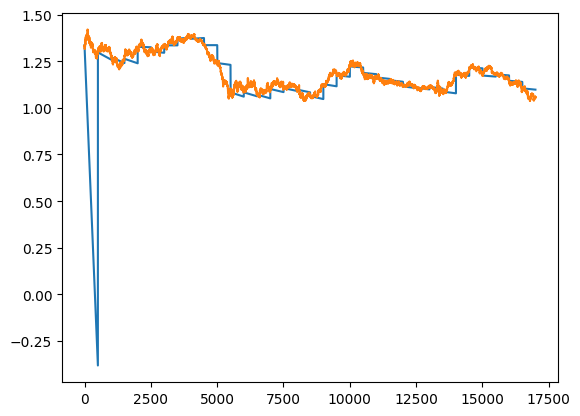

In [22]:
plt.plot(tscv.model.pred_insample)
plt.plot(tscv.dataset.train['Close'].values)

For AMZN MAPE: 4.95% RMSPE: 7.62% (in sample)


For AMZN MAPE: 1.66% RMSPE: 2.02% (out of sample)

({'mean_absolute_percentage_error': 0.04956305, 'rmspe': 0.07629055},
 {'mean_absolute_percentage_error': 0.016662065, 'rmspe': 0.02026258})

EURUSD 4h
({'mean_absolute_percentage_error': 0.0024390433, 'rmspe': 0.0035899489},
 {'mean_absolute_percentage_error': 0.0024496086, 'rmspe': 0.0031022483})

USDJPY 4h
({'mean_absolute_percentage_error': 0.0024852448, 'rmspe':  0.0037517922},
 {'mean_absolute_percentage_error': 0.002553856, 'rmspe': 0.0032066398})

USDJPY 1m ({'mean_absolute_percentage_error': 0.00015067536, 'rmspe': 0.00025786713},
 {'mean_absolute_percentage_error': 7.9848774e-05, 'rmspe': 0.00010066714})

## LSTM test

In [19]:
from src.utils import clean_data
from src.preprocessing import DataSet
from src.forecast import TSCV

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError

In [14]:
CURR = "EURUSD"
INTERVAL = "4h"
eurusd = load(currency=CURR, interval=INTERVAL)
eurusd = clean_data(eurusd)
data = DataSet(data=eurusd, ratios=[0.95, 0.05], label=['target_value'])
tscv = TSCV(dataset=data,
            n_splits=3,
            test_size=20)

In [37]:
train_x, train_y = data.train.drop(columns=['target_value']), data.train.target_value
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).bathc(32)

AttributeError: '_TensorSliceDataset' object has no attribute 'bathc'

In [38]:
# define model
model = tf.keras.models.Sequential(
    [LSTM(32, input_shape=(None, 49)),
    Dense(1)]
)
model.compile(
    optimizer=Adam(),
    loss=MeanAbsoluteError(),
    metrics=RootMeanSquaredError()
)
model.fit(train_data, epochs=3)

Epoch 1/3


ValueError: in user code:

    File "/Users/sebastiansukiennik/.pyenv/versions/3.9.6/envs/BACH/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/sebastiansukiennik/.pyenv/versions/3.9.6/envs/BACH/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/sebastiansukiennik/.pyenv/versions/3.9.6/envs/BACH/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/sebastiansukiennik/.pyenv/versions/3.9.6/envs/BACH/lib/python3.9/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/Users/sebastiansukiennik/.pyenv/versions/3.9.6/envs/BACH/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/sebastiansukiennik/.pyenv/versions/3.9.6/envs/BACH/lib/python3.9/site-packages/keras/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_4' (type Sequential).
    
    Input 0 of layer "lstm_14" is incompatible with the layer: expected ndim=3, found ndim=1. Full shape received: (49,)
    
    Call arguments received by layer 'sequential_4' (type Sequential):
      • inputs=tf.Tensor(shape=(49,), dtype=float64)
      • training=True
      • mask=None


In [55]:
import pandas as pd
grid_res = ['gridSearchResults/CLSTM_dense_2.csv', 'gridSearchResults/CLSTM_lstm_2.csv', 'gridSearchResults/CLSTM_cnn_2.csv']
res_name = grid_res[0]


In [56]:
res = pd.read_csv(res_name, index_col=[0])
res.iloc[:5, 2:].to_clipboard()